In [1]:
# Import statements
import os
import numpy as np
import pandas as pd

# Import Pyomo libraries
from pyomo.environ import (
    ConcreteModel,
    SolverFactory,
    value,
    Var,
    Constraint,
    Set,
    Objective,
    maximize,
)
from pyomo.common.timing import TicTocTimer

# Import IDAES libraries
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.alamopy import AlamoTrainer, AlamoSurrogate
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core import FlowsheetBlock
from idaes.core.util.convergence.convergence_base import _run_ipopt_with_stats

In [2]:
# Import Auto-reformer training data
np.set_printoptions(precision=6, suppress=True)

# Reading the data from excel and sampling from it. 
csv_data = pd.read_excel("./output_2_evap_sakshi_model_saturation.xlsx")  
csv_data.dropna(inplace=True)
data = csv_data.sample(n=len(csv_data)) 

# Defining the input and the output columns
input_data=data[['Inlet','Recovery','Flow']]
output_data = data[['CAPEX','OPEX','Energy']]

In [3]:
# randomly sample points for training/validation
# Define labels, and split training and validation data
input_labels = input_data.columns
output_labels = output_data.columns

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(
    data, 0.8, seed=n_data
)  # seed=100

In [4]:
# Visualizing the dataframe to make sure things are in order
data

,Inlet,Outlet,Flow,CAPEX,OPEX,Energy,Recovery,Status
1247,48.469388,51.020408,9444.444444,247.842108,2229.044741,1592.174815,0.05,1
2941,132.653061,241.187384,20000.000000,545.789478,6216.216060,4440.154329,0.45,1
2326,129.285714,152.100840,15777.777778,159.940629,1230.027204,878.590860,0.15,1
814,129.285714,235.064935,5222.222222,132.895817,951.557826,679.684161,0.45,1
240,149.489796,271.799629,1000.000000,35.974733,108.608230,77.577307,0.45,1
...,...,...,...,...,...,...,...,...
2731,35.000000,63.636364,20000.000000,532.719856,6025.686450,4304.061750,0.45,1
819,132.653061,204.081633,5222.222222,108.317070,709.951556,507.108254,0.35,1
2577,98.979592,219.954649,17888.888889,623.664565,7387.480416,5276.771726,0.55,1
247,156.224490,183.793517,1000.000000,34.321308,97.958860,69.970614,0.15,1


In [5]:
# Create ALAMO trainer object
trainer = AlamoTrainer(
    input_labels=input_labels,
    output_labels=output_labels,
    training_dataframe=data_training,
)

# Scaling
# trainer.config.xfactor = list(input_data.max()-input_data.min())
trainer.config.xscaling = True
trainer.config.scalez = True
# trainer.config.grbfcns = True
# trainer.config.rbfparam = True
# Set ALAMO options
trainer.config.constant = True
trainer.config.linfcns = True
trainer.config.logfcns = True
trainer.config.expfcns = True
trainer.config.sinfcns = True
trainer.config.cosfcns = True
trainer.config.multi2power = [1, 2, 3, 4, 5, 6, 7, 8,  9 ,10, 11, 12, 13, 14, 15]
trainer.config.multi3power = [1, 2, 3, 4, 5, 6, 7, 8,  9 ,10, 11, 12, 13, 14, 15]
trainer.config.monomialpower = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
trainer.config.ratiopower = [1, 2, 3, 4 ,5]
trainer.config.maxterms = [30] * len(output_labels)  # max for each surrogate
trainer.config.filename = os.path.join(os.getcwd(), "alamo_run.alm")
trainer.config.overwrite_files = True

# Train surrogate (calls ALAMO through IDAES ALAMOPy wrapper)
has_alamo = True
try:
    success, alm_surr, msg = trainer.train_surrogate()
except FileNotFoundError as err:
    if "Could not find ALAMO" in str(err):
        print("ALAMO not found. You must install ALAMO to use this notebook")
        has_alamo = False
    else:
        raise

if has_alamo:
    # save model to JSON
    model = alm_surr.save_to_file("alamo_surrogate.json", overwrite=True)

    # create callable surrogate object

    surrogate_expressions = trainer._results["Model"]
    input_labels = trainer._input_labels
    output_labels = trainer._output_labels
    xmin, xmax = [35.00, 0.05,1000.00], [200,0.95,20000.00]
    input_bounds = {
        input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))
    }
    alm_surr = AlamoSurrogate(
        surrogate_expressions, input_labels, output_labels, input_bounds
    )
    surr=AlamoSurrogate.load_from_file("./alamo_surrogate.json")
    from sklearn.metrics import r2_score
    x_test=input_data
    y_true=data.iloc[:,3:6]
    y_pred=surr.evaluate_surrogate(x_test)
    r2=r2_score(y_true, y_pred)

 ***************************************************************************
 ALAMO version 2023.2.13. Built: WIN-64 Mon Feb 13 21:30:56 EST 2023

 If you use this software, please cite:
 Cozad, A., N. V. Sahinidis and D. C. Miller,
 Automatic Learning of Algebraic Models for Optimization,
 AIChE Journal, 60, 2211-2227, 2014.

 ALAMO is powered by the BARON software from http://www.minlp.com/
 ***************************************************************************
 Licensee: Javal Vyas at Carnegie Mellon University, jvyas@andrew.cmu.edu.
 ***************************************************************************
 Reading input data
 Checking input consistency and initializing data structures
 
 Step 0: Initializing data set
 User provided an initial data set of 2342 data points
 We will sample no more data points at this stage
 ***************************************************************************
 Iteration 1 (Approx. elapsed time 0.34 s)
 
 Step 1: Model building using BIC


In [6]:
print(f'R2 score = {r2:.4f}')

R2 score = 0.9602


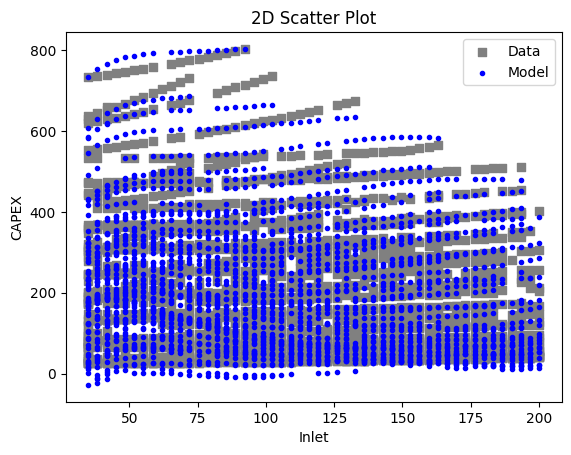

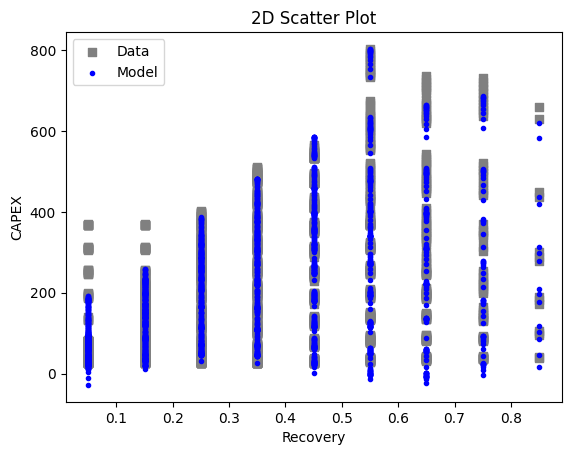

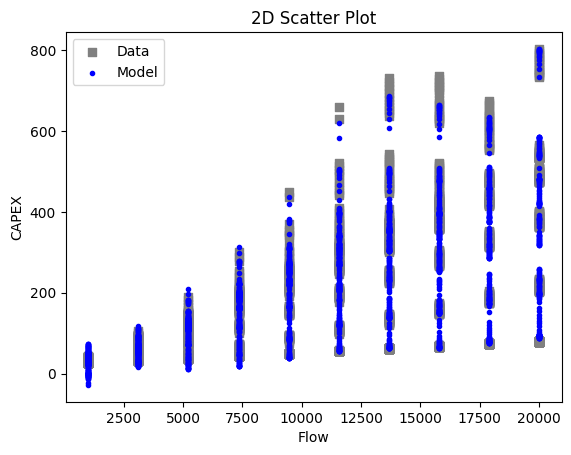

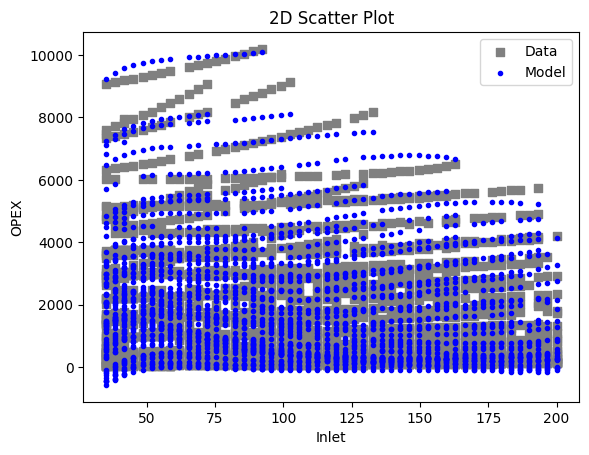

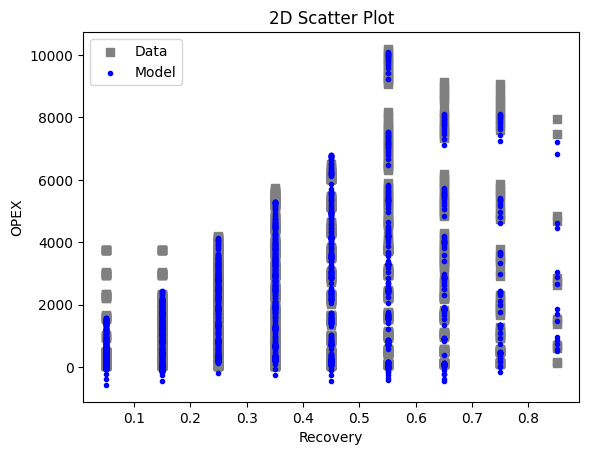

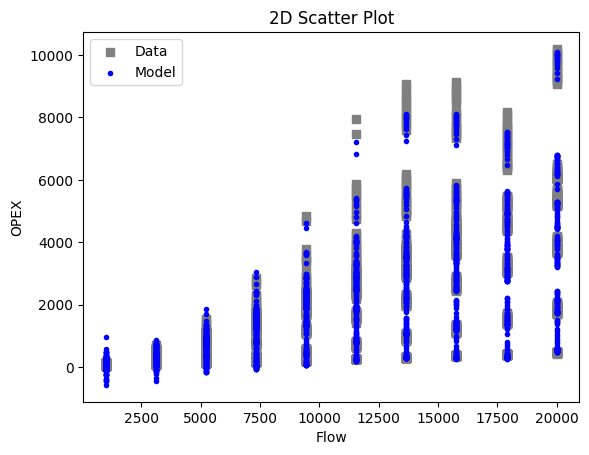

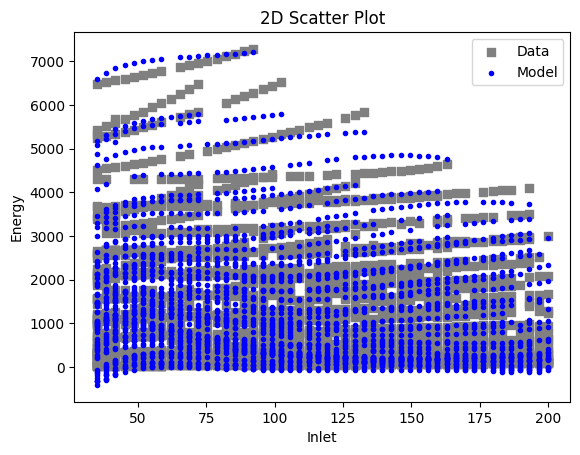

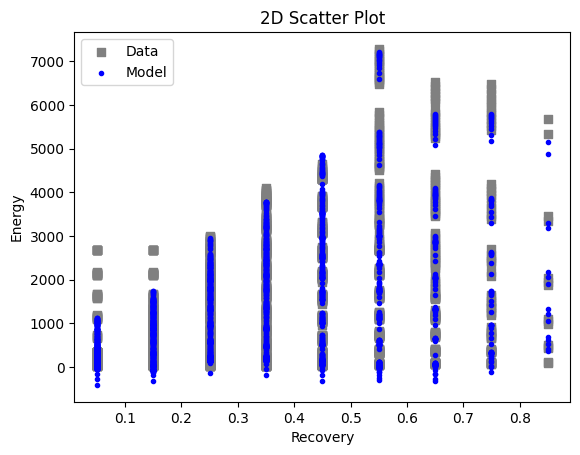

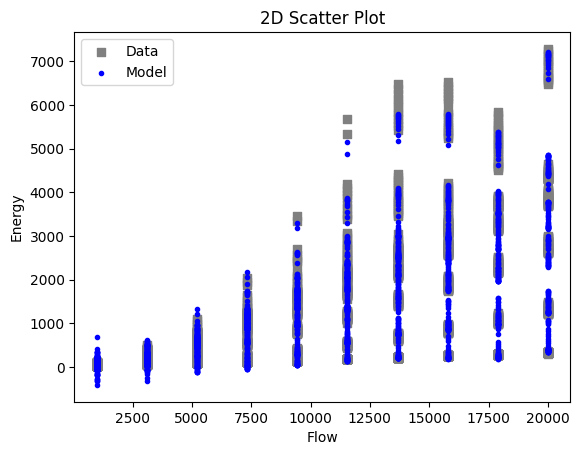

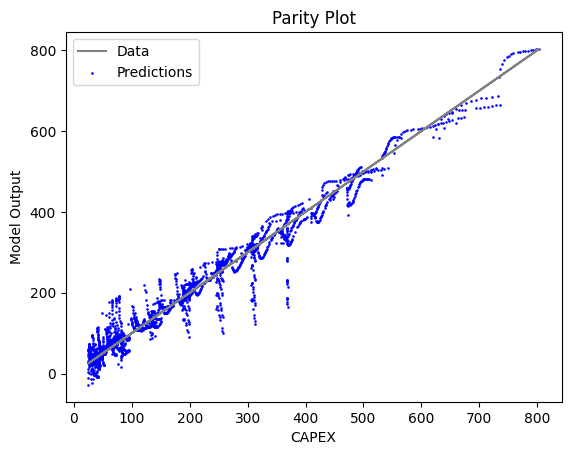

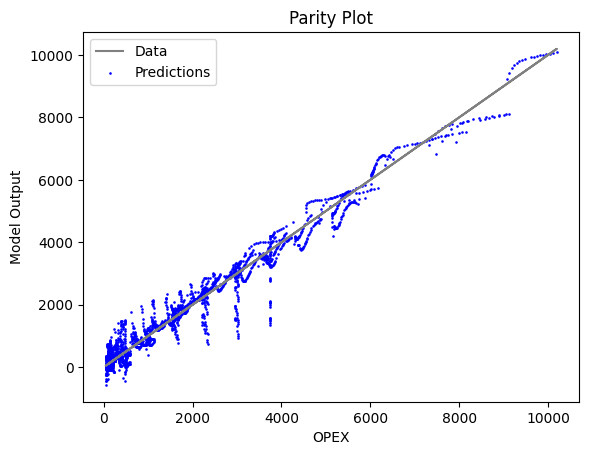

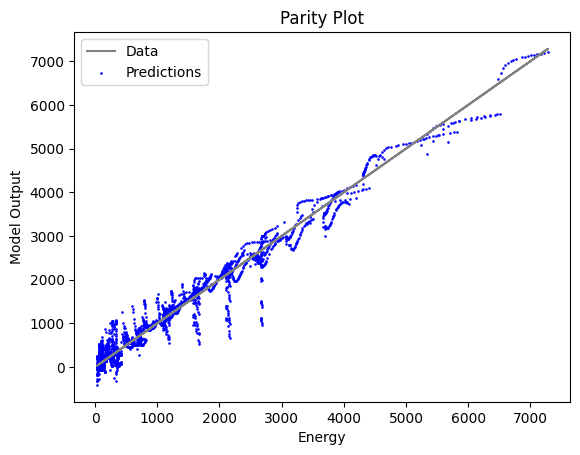

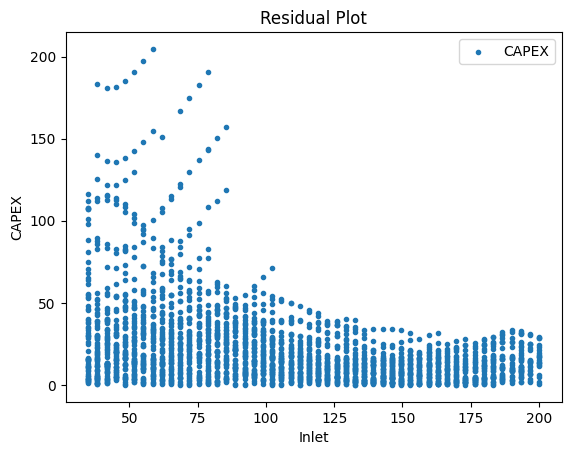

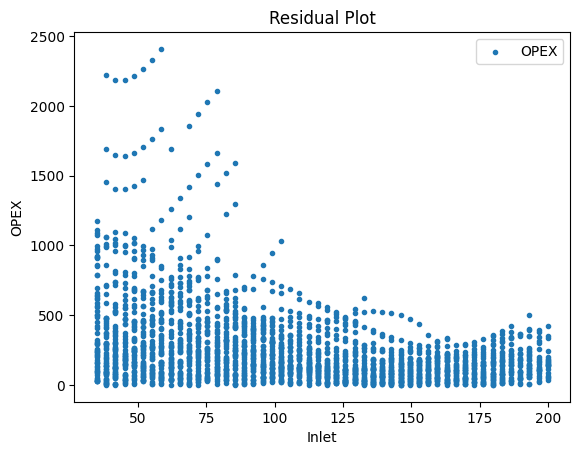

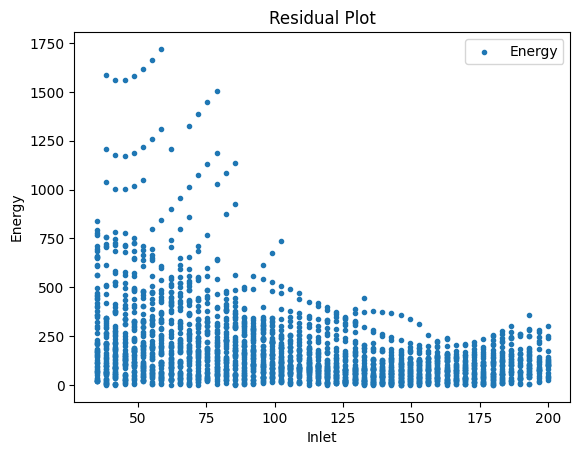

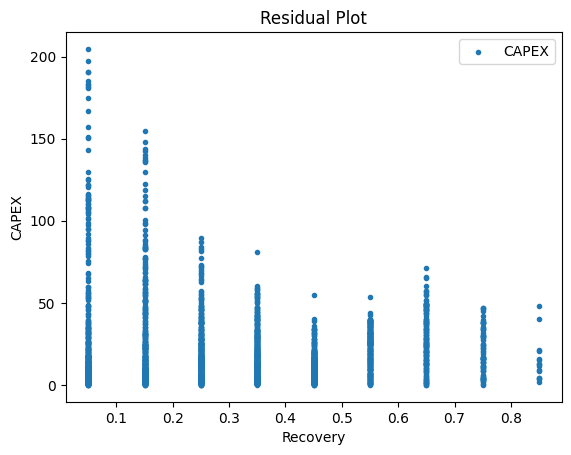

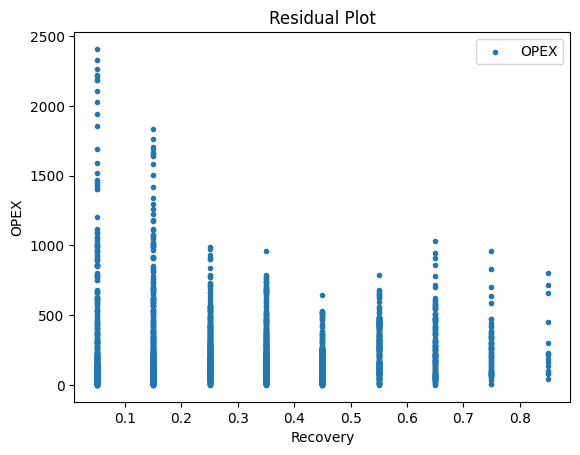

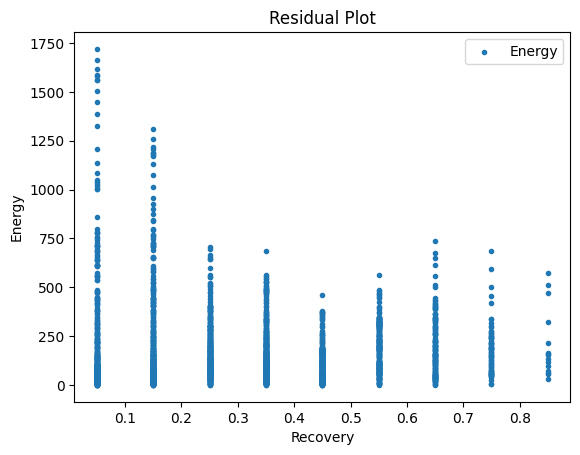

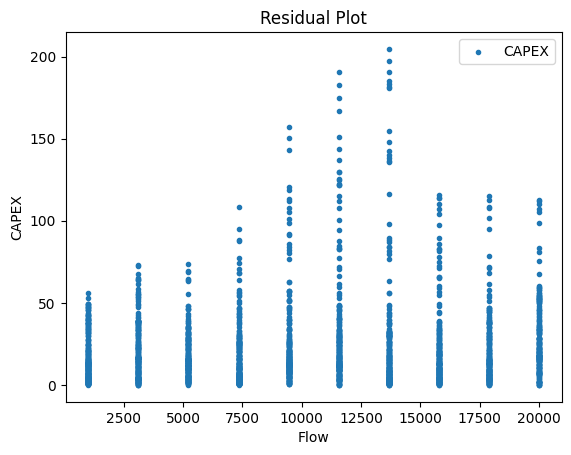

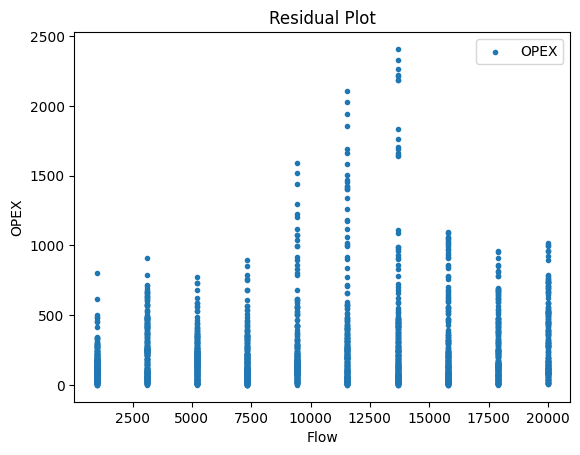

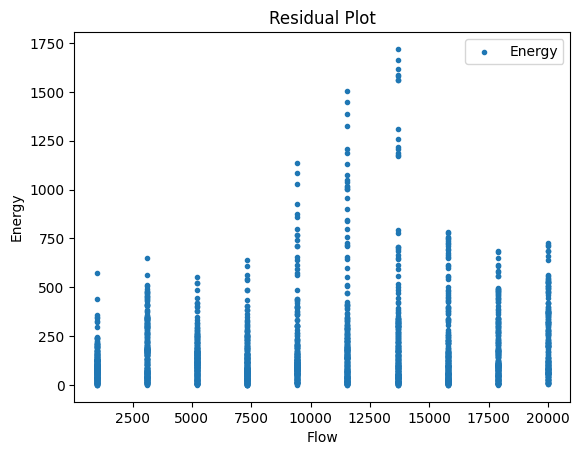

In [7]:
if has_alamo:
    # visualize with IDAES surrogate plotting tools
    surrogate_scatter2D(alm_surr, data_training, filename="alamo_train_scatter2D.pdf")
    surrogate_parity(alm_surr, data_training, filename="alamo_train_parity.pdf")
    surrogate_residual(alm_surr, data_training, filename="alamo_train_residual.pdf")